In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
warnings.simplefilter('ignore')

In [110]:
# Importando os dados de preço da ação desde que foi listada na bolsa

ticker = yf.Ticker("RRRP3.SA")
ticker = ticker.history(period="max")

In [111]:
data = ticker.copy()

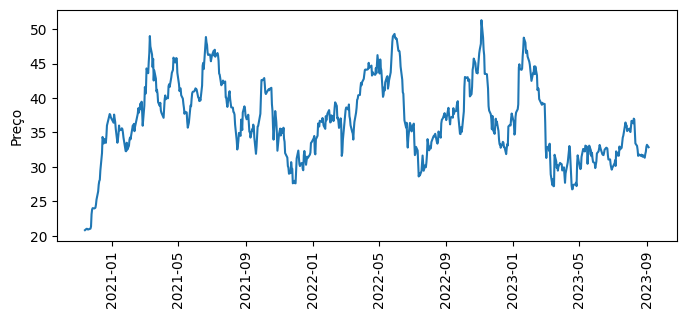

In [112]:
# Plotando um grafico de linha para verificar o comportamento do preço de fechamento
plt.figure(figsize=(8, 3))
plt.plot(data.index, data["Close"])
plt.ylabel("Preço")
plt.xticks(rotation=90)
plt.show()

In [113]:
# Definindo o alvo do modelo

df = data[['Close']]
df.rename(columns={'Close':'Fechamento Atual'}, inplace=True)
df["Target"] = ticker.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])['Close']

In [114]:
ticker_prev = data.copy()
ticker_prev = ticker_prev.shift(1)

In [115]:
ticker_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-11-13 00:00:00-03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-16 00:00:00-03:00,21.000000,21.35,20.799999,20.799999,470000.0,0.0,0.0
2020-11-17 00:00:00-03:00,21.150000,21.25,20.969999,21.000000,175800.0,0.0,0.0
2020-11-18 00:00:00-03:00,20.940001,20.99,20.650000,20.990000,256600.0,0.0,0.0
2020-11-19 00:00:00-03:00,20.990000,21.07,20.900000,20.900000,96600.0,0.0,0.0


In [116]:
# Definindo os preditores iniciais do modelo

predictors = ["Close", "High", "Low", "Open", "Volume"]
df = df.join(ticker_prev[predictors]).iloc[1:]

In [117]:
df.head()

,Fechamento Atual,Target,Close,High,Low,Open,Volume
Date,,,,,,,
2020-11-16 00:00:00-03:00,21.00,1.0,20.799999,21.350000,20.799999,21.000000,470000.0
2020-11-17 00:00:00-03:00,20.99,0.0,21.000000,21.250000,20.969999,21.150000,175800.0
2020-11-18 00:00:00-03:00,20.90,0.0,20.990000,20.990000,20.650000,20.940001,256600.0
2020-11-19 00:00:00-03:00,20.90,0.0,20.900000,21.070000,20.900000,20.990000,96600.0
2020-11-23 00:00:00-03:00,21.02,1.0,20.900000,21.040001,20.820000,21.000000,84300.0


In [118]:
# Setando o modelo

model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=42)

train = df.iloc[:-100]
test = df.iloc[-100:]

model.fit(train[predictors], train["Target"])
preds = model.predict_proba(test[predictors])[:, 1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds <= .6] = 0

In [119]:
precision_score(test["Target"], preds)

0.7619047619047619

In [120]:
combined = pd.concat({"Target":test["Target"], "Predictions":preds}, axis = 1)

<Axes: xlabel='Date'>

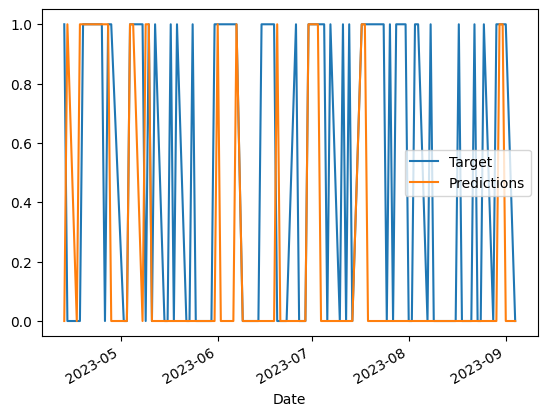

In [121]:
combined.plot()

In [122]:
# Fazendo backtest para verificar se a predição do modelo foi correta

start = 100 
step = 75


def backtest(df, model, predictors, start=100, step=50):
    predictions = []
    for i in range(start, data.shape[0], step):
        train = df.iloc[0:i].copy()
        test = df.iloc[i:(i+step)].copy()
        model.fit(train[predictors], train["Target"])

        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds <= .6] = 0

        combined = pd.concat({"Target": test["Target"], "Predictions":preds}, axis =1)
        predictions.append(combined)

    predictions = pd.concat(predictions)
    return predictions

In [123]:
predictions["Predictions"].value_counts()

Predictions
0.0    446
1.0    151
Name: count, dtype: int64

In [124]:
precision_score(predictions["Target"], predictions["Predictions"])

0.7549668874172185

In [125]:
# Criando novas features para executar o modelo

df["media_semanal"] = df["Close"].rolling(7).mean()
df["media_trimestral"] = df["Close"].rolling(90).mean()

df["open_close_ratio"] = df["Open"] / data["Close"]
df["high_close_ratio"] = df["High"] / df["Close"]
df["low_close_ratio"] = df["Low"] / df["Close"]

full_predictors = predictors + ["media_semanal", "media_trimestral", "open_close_ratio", "high_close_ratio", "low_close_ratio"]

Text(0, 0.5, 'Preço')

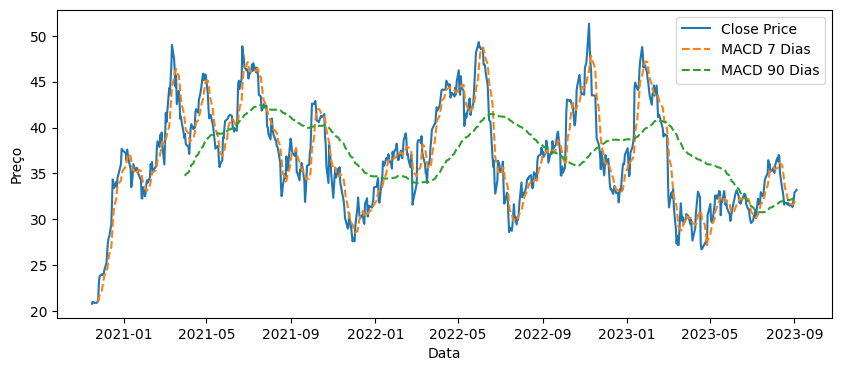

In [133]:
plt.figure(figsize=(10, 4))
plt.plot(df.index, df["Close"],'-', label="Close Price")
plt.plot(df.index, df["media_semanal"], '--',label="MACD 7 Dias")
plt.plot(df.index, df["media_trimestral"], '--', label="MACD 90 Dias")
plt.legend()
plt.xlabel("Data")
plt.ylabel("Preço")


In [100]:
df.fillna(0, inplace=True)

In [101]:
predictions = backtest(df, model, full_predictors, start=100, step=50)

In [90]:
precision_score(predictions["Target"], predictions["Predictions"])

0.7549668874172185

In [91]:
predictions["Predictions"].value_counts()

Predictions
0.0    446
1.0    151
Name: count, dtype: int64